In [42]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [43]:
#static parameters
train_batch_size = 115
val_batch_size = 115
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [44]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [45]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [46]:
network_output.shape

torch.Size([2361])

In [47]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [48]:
network_input.shape

torch.Size([2361, 50, 1])

In [49]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [50]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -61]
network_output = network_output[: -61]

print(network_input.shape)
print(network_output.shape)

torch.Size([2300, 50, 1])
torch.Size([2300])


In [51]:
#network_input[0]

In [52]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden,batch_size):
        
        output, hidden = self.lstm(x, hidden)        
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, self.hidden_size)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
          weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [29]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [30]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [31]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [32]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        h = tuple([each.data for each in hidden])
        

        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h = tuple([each.data for each in hidden])
        
        output, hidden = model.forward(inputs, val_h,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_hidden_size_sorted.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.5800878 	Val Loss:3.4100335 	Train Acc: 4.565217% 	Val Acc: 1.9565217%
Validation Loss decreased from    inf to 3.410033, saving the model weights
Epoch: 1	Train Loss: 3.4475122 	Val Loss:3.3310713 	Train Acc: 6.032609% 	Val Acc: 1.3043478%
Validation Loss decreased from 3.410033 to 3.331071, saving the model weights
Epoch: 2	Train Loss: 3.3626674 	Val Loss:3.1608108 	Train Acc: 3.423913% 	Val Acc: 8.4782608%
Validation Loss decreased from 3.331071 to 3.160811, saving the model weights
Epoch: 3	Train Loss: 3.3091430 	Val Loss:3.1385721 	Train Acc: 4.565217% 	Val Acc: 8.4782608%
Validation Loss decreased from 3.160811 to 3.138572, saving the model weights
Epoch: 4	Train Loss: 3.2835425 	Val Loss:3.1272240 	Train Acc: 5.163043% 	Val Acc: 8.4782608%
Validation Loss decreased from 3.138572 to 3.127224, saving the model weights
Epoch: 5	Train Loss: 3.2710857 	Val Loss:3.0958062 	Train Acc: 5.815217% 	Val Acc: 10.4347827%
Validation Loss decreased from 3.127224 to 3.09

Epoch: 63	Train Loss: 2.3476770 	Val Loss:2.2510800 	Train Acc: 25.21739% 	Val Acc: 24.3478253%
Validation Loss decreased from 2.300371 to 2.251080, saving the model weights
Epoch: 64	Train Loss: 2.3454483 	Val Loss:2.1930003 	Train Acc: 25.70652% 	Val Acc: 26.3043478%
Validation Loss decreased from 2.251080 to 2.193000, saving the model weights
Epoch: 65	Train Loss: 2.2857066 	Val Loss:2.1675405 	Train Acc: 24.83696% 	Val Acc: 29.3478262%
Validation Loss decreased from 2.193000 to 2.167540, saving the model weights
Epoch: 66	Train Loss: 2.2297305 	Val Loss:2.1673795 	Train Acc: 27.66304% 	Val Acc: 28.9130431%
Validation Loss decreased from 2.167540 to 2.167379, saving the model weights
Epoch: 67	Train Loss: 2.2146873 	Val Loss:2.2100551 	Train Acc: 28.6413% 	Val Acc: 27.8260872%
Epoch: 68	Train Loss: 2.2397944 	Val Loss:2.1746354 	Train Acc: 27.55435% 	Val Acc: 29.3478262%
Epoch: 69	Train Loss: 2.2216289 	Val Loss:2.1892306 	Train Acc: 28.04348% 	Val Acc: 26.7391298%
Epoch: 70	Train L

Epoch: 125	Train Loss: 0.9594826 	Val Loss:1.1261375 	Train Acc: 66.25% 	Val Acc: 63.9130443%
Epoch: 126	Train Loss: 0.9845151 	Val Loss:1.1035088 	Train Acc: 65.16304% 	Val Acc: 65.4347822%
Validation Loss decreased from 1.109676 to 1.103509, saving the model weights
Epoch: 127	Train Loss: 0.9484455 	Val Loss:1.0867271 	Train Acc: 65.97826% 	Val Acc: 65.0000013%
Validation Loss decreased from 1.103509 to 1.086727, saving the model weights
Epoch: 128	Train Loss: 1.0787035 	Val Loss:1.2981853 	Train Acc: 62.3913% 	Val Acc: 58.4782600%
Epoch: 129	Train Loss: 1.1985149 	Val Loss:1.1792511 	Train Acc: 58.47826% 	Val Acc: 59.1304354%
Epoch: 130	Train Loss: 1.2207013 	Val Loss:1.2850288 	Train Acc: 57.88043% 	Val Acc: 57.1739115%
Epoch: 131	Train Loss: 1.0913315 	Val Loss:1.0721450 	Train Acc: 62.22826% 	Val Acc: 65.2173921%
Validation Loss decreased from 1.086727 to 1.072145, saving the model weights
Epoch: 132	Train Loss: 0.9972819 	Val Loss:1.0782611 	Train Acc: 65.32609% 	Val Acc: 67.608

Epoch: 195	Train Loss: 0.2660764 	Val Loss:0.5547398 	Train Acc: 91.79348% 	Val Acc: 85.2173924%
Epoch: 196	Train Loss: 0.2624017 	Val Loss:0.4267513 	Train Acc: 92.71739% 	Val Acc: 88.2608697%
Epoch: 197	Train Loss: 0.2535840 	Val Loss:0.4352483 	Train Acc: 92.60869% 	Val Acc: 87.1739119%
Epoch: 198	Train Loss: 0.2476774 	Val Loss:0.4754654 	Train Acc: 92.66304% 	Val Acc: 87.6086950%
Epoch: 199	Train Loss: 0.2364490 	Val Loss:0.4444946 	Train Acc: 93.09783% 	Val Acc: 87.3913035%
Epoch: 200	Train Loss: 0.2783713 	Val Loss:0.4555673 	Train Acc: 90.70652% 	Val Acc: 86.0869557%
Epoch: 201	Train Loss: 0.2761138 	Val Loss:0.6352103 	Train Acc: 91.46739% 	Val Acc: 82.3913053%
Epoch: 202	Train Loss: 0.3056866 	Val Loss:0.5869964 	Train Acc: 90.0% 	Val Acc: 84.3478262%
Epoch: 203	Train Loss: 0.3187260 	Val Loss:0.4505945 	Train Acc: 89.83696% 	Val Acc: 88.4782612%
Epoch: 204	Train Loss: 0.2914323 	Val Loss:0.5617566 	Train Acc: 90.92391% 	Val Acc: 84.7826093%
Epoch: 205	Train Loss: 0.2788032 	

Epoch: 273	Train Loss: 0.1208166 	Val Loss:0.2269965 	Train Acc: 96.90217% 	Val Acc: 92.8260848%
Validation Loss decreased from 0.247615 to 0.226996, saving the model weights
Epoch: 274	Train Loss: 0.1130716 	Val Loss:0.3115350 	Train Acc: 97.17391% 	Val Acc: 90.0000006%
Epoch: 275	Train Loss: 0.1246133 	Val Loss:0.4842424 	Train Acc: 95.92391% 	Val Acc: 85.4347825%
Epoch: 276	Train Loss: 0.1345046 	Val Loss:0.2880213 	Train Acc: 95.92391% 	Val Acc: 90.8695653%
Epoch: 277	Train Loss: 0.1411939 	Val Loss:0.2460197 	Train Acc: 95.81522% 	Val Acc: 91.7391300%
Epoch: 278	Train Loss: 0.1505245 	Val Loss:0.2347003 	Train Acc: 95.48913% 	Val Acc: 92.8260878%
Epoch: 279	Train Loss: 0.1382496 	Val Loss:0.3265686 	Train Acc: 96.1413% 	Val Acc: 91.3043484%
Epoch: 280	Train Loss: 0.1111638 	Val Loss:0.4062714 	Train Acc: 96.90217% 	Val Acc: 88.6956513%
Epoch: 281	Train Loss: 0.1138625 	Val Loss:0.3403232 	Train Acc: 96.79348% 	Val Acc: 90.8695638%
Epoch: 282	Train Loss: 0.1211178 	Val Loss:0.33042

Epoch: 356	Train Loss: 0.0339312 	Val Loss:0.2424775 	Train Acc: 99.34783% 	Val Acc: 93.6956510%
Epoch: 357	Train Loss: 0.0364217 	Val Loss:0.2164057 	Train Acc: 99.18478% 	Val Acc: 95.2173904%
Epoch: 358	Train Loss: 0.0362722 	Val Loss:0.2184731 	Train Acc: 99.18478% 	Val Acc: 95.0000003%
Epoch: 359	Train Loss: 0.0384921 	Val Loss:0.2761793 	Train Acc: 98.91304% 	Val Acc: 93.0434793%
Epoch: 360	Train Loss: 0.0313821 	Val Loss:0.2332259 	Train Acc: 99.34783% 	Val Acc: 94.1304326%
Epoch: 361	Train Loss: 0.0362576 	Val Loss:0.2328502 	Train Acc: 99.45652% 	Val Acc: 93.9130425%
Epoch: 362	Train Loss: 0.0349799 	Val Loss:0.2280926 	Train Acc: 99.13043% 	Val Acc: 94.9999988%
Epoch: 363	Train Loss: 0.0267541 	Val Loss:0.2653196 	Train Acc: 99.45652% 	Val Acc: 92.8260863%
Epoch: 364	Train Loss: 0.0305953 	Val Loss:0.2466757 	Train Acc: 99.45652% 	Val Acc: 94.3478242%
Epoch: 365	Train Loss: 0.0301339 	Val Loss:0.2661777 	Train Acc: 99.40217% 	Val Acc: 93.6956525%
Epoch: 366	Train Loss: 0.03348

Epoch: 441	Train Loss: 0.0360420 	Val Loss:0.2723735 	Train Acc: 99.29348% 	Val Acc: 94.3478242%
Epoch: 442	Train Loss: 0.0338480 	Val Loss:0.2721491 	Train Acc: 99.51087% 	Val Acc: 93.9130425%
Epoch: 443	Train Loss: 0.0340063 	Val Loss:0.2801941 	Train Acc: 99.40217% 	Val Acc: 94.1304341%
Epoch: 444	Train Loss: 0.0356678 	Val Loss:0.2780287 	Train Acc: 98.80435% 	Val Acc: 93.9130425%
Epoch: 445	Train Loss: 0.0328779 	Val Loss:0.2803798 	Train Acc: 99.45652% 	Val Acc: 93.9130425%
Epoch: 446	Train Loss: 0.0287683 	Val Loss:0.2760672 	Train Acc: 99.67391% 	Val Acc: 94.1304326%
Epoch: 447	Train Loss: 0.0332231 	Val Loss:0.2885443 	Train Acc: 99.18478% 	Val Acc: 93.4782609%
Epoch: 448	Train Loss: 0.0306620 	Val Loss:0.2908644 	Train Acc: 99.67391% 	Val Acc: 93.0434763%
Epoch: 449	Train Loss: 0.0361704 	Val Loss:0.3042476 	Train Acc: 99.13043% 	Val Acc: 93.2608679%
Epoch: 450	Train Loss: 0.0322805 	Val Loss:0.3101678 	Train Acc: 99.29348% 	Val Acc: 92.8260863%
Epoch: 451	Train Loss: 0.02709

#### Music Genaration


In [33]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_hidden_size_sorted.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [34]:
#load population database

#testing_data = np.ones(200)*1
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [35]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [36]:
#testing_data

In [37]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    test_hidden = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output,_ = test_model.forward(test_slice, test_hidden, test_batch_size)
        test_output = F.softmax(test_output, dim = 1)
    
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [38]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [39]:
#predicted_notes_lst

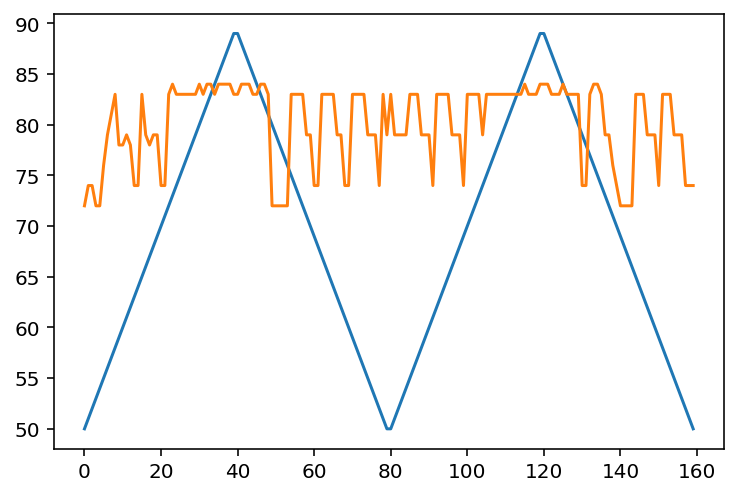

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [41]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 12, 74: 20, 76: 2, 79: 32, 81: 1, 83: 69, 78: 4, 84: 20})